<a href="https://colab.research.google.com/github/alexandreib/QuantDesign/blob/main/SP500_Portfolio_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Portfolio Optimization on S&P 500 Stocks**



In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

# Download the Stocks Returns


## Scraping SP500 Tickers

In [2]:
# Download the S&P 500 constituents from Wikipedia
try:
    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    tickers = df['Symbol'].tolist()
except Exception as e:
    print(f"Error downloading S&P 500 tickers: {e}")
    tickers = [] # Handle the error gracefully, e.g., provide a default list

# Print or use the tickers list
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMTM', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', '

## Download the last 10 years of price

In [3]:
# Define the start and end dates for the data
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=365 * 10)

# Download the data
df = yf.download(tickers, start=start_date, end=end_date)

# Print the data (optional)
df.head()

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-11-01 02:50:06.743240 -> 2024-10-29 02:50:06.743240)')


Price                      Adj Close                                        \
Ticker                             A       AAPL       ABBV ABNB        ABT   
Date                                                                         
2014-11-03 00:00:00+00:00  37.588352  24.284266  41.817745  NaN  35.778111   
2014-11-04 00:00:00+00:00  36.980892  24.106680  41.427666  NaN  36.042595   
2014-11-05 00:00:00+00:00  36.934875  24.164389  41.348335  NaN  36.083916   
2014-11-06 00:00:00+00:00  38.076149  24.233513  41.460720  NaN  36.108719   
2014-11-07 00:00:00+00:00  37.671185  24.302620  40.660736  NaN  35.844223   

Price                                                                  \
Ticker                          ACGL        ACN       ADBE        ADI   
Date                                                                    
2014-11-03 00:00:00+00:00  18.799999  68.641075  69.910004  40.260704   
2014-11-04 00:00:00+00:00  18.910000  68.793648  71.070000  40.042065   
2014-11-05 00:00:00+00:00  18.906668  69.921150  71.370003  40.511723   
2014-11-06 00:00:00+00:00  19.026667  70.565422  72.099998  40.665562   
2014-11-07 00:00:00+00:00  19.160000  70.768875  71.599998  40.681759   

Price                                 ...  Volume                             \
Ticker                           ADM  ...     WTW       WY     WYNN      XEL   
Date                                  ...                                      
2014-11-03 00:00:00+00:00  35.714283  ...  504566  3013800  1222900  3243800   
2014-11-04 00:00:00+00:00  37.445206  ...  440467  2763400  2088000  3709800   
2014-11-05 00:00:00+00:00  38.027206  ...  309965  3056200  2938200  4556000   
2014-11-06 00:00:00+00:00  37.770222  ...  398564  2924200  3081700  8182500   
2014-11-07 00:00:00+00:00  38.208630  ...  369837  2184200  1489600  4070000   

Price                                                                    \
Ticker                          XOM      XYL      YUM      ZBH     ZBRA   
Date                                                                      
2014-11-03 00:00:00+00:00  13410000   781100  4277047   813082   833000   
2014-11-04 00:00:00+00:00  13498500   693800  3248402  1050703  1544000   
2014-11-05 00:00:00+00:00  12480000   823700  2750842  1231983  1475600   
2014-11-06 00:00:00+00:00  14731400  1218200  3727741   764054   816600   
2014-11-07 00:00:00+00:00  13233500   669300  3368446   854694   507200   

Price                                
Ticker                          ZTS  
Date                                 
2014-11-03 00:00:00+00:00   4071300  
2014-11-04 00:00:00+00:00   9723700  
2014-11-05 00:00:00+00:00  11878900  
2014-11-06 00:00:00+00:00   4457100  
2014-11-07 00:00:00+00:00   6819000  

[5 rows x 3018 columns]

## Reshape, and Clean the DataFrame

In [4]:
# Reshape the DataFrame
df = df['Adj Close'].reset_index()
df = pd.melt(df, id_vars='Date', value_vars=tickers, var_name='Ticker', value_name='Adj Close')
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.rename(columns={'index': 'Ticker'})

# Print or use the transformed DataFrame
df.head()

,Date,Ticker,Adj Close
0,2014-11-03,MMM,91.496246
1,2014-11-04,MMM,92.540718
2,2014-11-05,MMM,92.922707
3,2014-11-06,MMM,93.137589
4,2014-11-07,MMM,93.436005


# Prepare the Returns

## Log Returns

Using log returns instead of simple returns has several advantages, especially in financial analysis:

1. **Time Additivity**
Log returns are time-additive, meaning that you can sum them over different periods to get the total return. For example, if you have daily log returns, you can sum them to find the cumulative return over a week or month.
Simple returns, on the other hand, do not have this property and require a more complex calculation for cumulative returns.
2. **Handling Compounding**
Log returns account for compounding naturally. When returns are compounded, log returns provide a more accurate measure of the growth of an investment over time.
Simple returns can underestimate or overestimate returns if not compounded properly.
3. **Normality Assumption**
Log returns tend to be more normally distributed than simple returns, particularly for large datasets. This property is useful for statistical modeling and risk management.
4. **Symmetry**
Log returns treat gains and losses symmetrically. A 10% gain followed by a 10% loss results in a net loss in simple returns, but the log returns more accurately reflect the continuous nature of returns.
5. **Ease of Analysis**
Many financial models, like the Black-Scholes option pricing model, rely on the normal distribution, making log returns more compatible with such models.

**Conclusion** <br>
While simple returns are easier to calculate and interpret for short-term analyses, log returns are generally more robust and useful for long-term investments and statistical analyses, especially when compounding and time periods are involved.

In [5]:
# Calculate daily log returns
df['Daily_Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# # Calculate quarterly log returns Using the first advantage of log Rturns : Tie Additivity
df['Quarterly_Log_Return'] = df.groupby('Ticker')['Daily_Log_Return'].rolling(window=63, min_periods=1).sum().reset_index(0,drop=True)

# Creation of the log return Matrix
log_returns_matrix = pd.pivot_table(df[['Date','Ticker', 'Quarterly_Log_Return']], index ='Date', columns = 'Ticker', aggfunc='mean')
log_returns_matrix = log_returns_matrix.droplevel(0, axis = 'columns')
log_returns_matrix.head(1)


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-03,-1.071875,0.024354,-1.003492,NaN,-0.766469,-1.320336,-1.016447,-1.642555,-0.534082,-1.084676,...,0.551777,-1.100306,-0.587804,-1.387013,-0.998862,-0.705716,-1.117708,-1.300811,-0.601795,-1.080535


## Shrinked Covariance Matrice

In situations with many variables and skewed data, using a shrinkage covariance matrix is typically the better choice.
Here's why, we will use the Shrinkage Covariance Matrix :

1.  **High Dimensionality:** When the number of variables is large relative to the number of observations, the standard covariance matrix can become unstable and lead to overfitting. Shrinkage helps to stabilize these estimates.

2.   **Skewed Data:** Skewed data can affect the estimation of the covariance matrix. Shrinkage techniques can provide more robust estimates by incorporating prior information or adjusting the influence of extreme values.

3.   **Variance Reduction:** Shrinkage methods reduce the variance of the covariance estimates, which is particularly beneficial in high dimensions. This can improve the reliability of downstream analyses, such as portfolio optimization or classification.

4.  **Bias-Variance Trade-off:** While shrinkage introduces some bias, it often results in a lower mean squared error compared to the traditional covariance matrix, especially in high-dimensional contexts.

**Conclusion** <br>
Given the presence of many variables and skewed data, a shrunk covariance matrix is generally more effective, as it mitigates the instability and variability issues that arise in such scenarios. Techniques like Ledoit-Wolf shrinkage or other regularization methods can be particularly useful.

In [6]:
def calculate_shrink_cov_matrix (df) :
    masked_arr = np.ma.array(df, mask=np.isnan(df))
    cov_numpy = np.ma.cov(masked_arr, rowvar=False, allow_masked=True, ddof=1).data
    n_samples, n_features = df.shape
    alpha = np.mean(cov_numpy**2)
    mu = np.trace(cov_numpy) / n_features
    mu_squared = mu**2
    num = alpha + mu_squared
    den = (n_samples + 1) * (alpha - mu_squared / n_features)
    shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
    shrunk_cov = (1.0 - shrinkage) * cov_numpy
    shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
    return shrunk_cov

covariance_matrix = calculate_shrink_cov_matrix(log_returns_matrix)



## Prepare data
We will take for returns only the positive past quarter returns (it's safe assumption that we will not invest in stocks which we assume will have negative returns).

We take the last quarter return, considering the momentum is strong enough to have similars returns the next quarter.

Let do the random allocation again with only the positive expected returns.


In [7]:
# Filter returns
log_returns = log_returns_matrix.iloc[-1]
log_returns = log_returns[log_returns > 0]

#get list of tickers
l_tickers = list(log_returns.index)

number_of_tickers = len(l_tickers)
# Out of Curiositry how many stock where with positive returns in the SP500 in the last quarter :
print(f"number_of_tickers with postivie returns in the last quarter : {number_of_tickers}")

# Store the individual stock standard deviation for future use
std_dev_individual_stocks = log_returns_matrix[l_tickers].std()

# Recalculate teh covariance Matrice
covariance_matrix = calculate_shrink_cov_matrix(log_returns_matrix[l_tickers])

number_of_tickers with postivie returns in the last quarter : 346


# Portfolio Allocation

## Random Portfolio allocation

In the next paragraph we will randomly assign weight to the different stocks, and calcualte the return, standard deviation, and sharpe ratio.

We do that for 5000 simulations and plot the results.

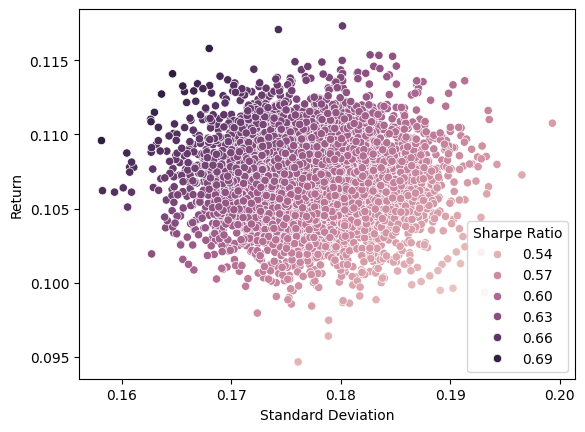

In [8]:
l_results = []
for idx in range(5000):
    weights = np.array(np.random.random(number_of_tickers))
    weights = weights / np.sum(weights) ## weights total < 1

    Returns = np.sum(log_returns * weights)
    Standard_Deviation = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    Sharpe_Ratio = Returns/Standard_Deviation
    Model = 'Random allocation'
    l_results.append([Returns, Standard_Deviation, Sharpe_Ratio, Model])

results = pd.DataFrame(l_results, columns = ['Return', 'Standard Deviation', 'Sharpe Ratio', 'Model'])

sns.scatterplot(results, x='Standard Deviation',  y='Return', hue = 'Sharpe Ratio')
plt.show()

What is the average Sharpe ratio, return and standard deviation in the above simulation

In [9]:
results_mean = results[['Return', 'Standard Deviation', 'Sharpe Ratio']].mean()
display(results_mean)

,0
Return,0.106946
Standard Deviation,0.177506
Sharpe Ratio,0.603057


The random weight allocation portfolio demonstrate significant variability, highlighting the unpredictability of returns without a strategic approach. While it serves as a useful benchmark, it underscores the importance of informed asset selection to achieve consistent performance and risk management.

## Optimized Portfolio Allocation

**Mean Variance Optimization :**

 $\qquad$ Mean-variance portfolio optimization is a method for constructing portfolios that maximize returns for a given risk level or, conversely, minimize risk for a given expected return. It balances the trade-off between return and risk by optimizing asset weights in a portfolio.

The optimization problem can be formulated as:

- **Objective, Maximize : $$R_p - \lambda \cdot \sigma_p^2$$**

where:
- - $R_p = \sum_{i=1}^{n} w_i \cdot R_i$ Portfolio return.
    - $w$ : Weight of the portfolio
    - $R_i$ : Return of invdividual stock
    
- $\sigma_p^2 = w^T \Sigma w $ : Portfolio variance (risk).
    - $\Sigma$ : Covariance Matrice
- $\lambda $ : Risk aversion parameter, where higher values prioritize minimizing risk.

Solving this problem yields the optimal asset weights, creating a portfolio on the **efficient frontier**—the set of portfolios with the best return-risk trade-off.

<br>

**Sharpe Ratio Optimization :**


 $\qquad$ The Sharpe Ratio is a metric that helps investors understand the return on an investment relative to its risk. It considers not just how much an investment is expected to earn but also how much volatility or risk is involved to achieve those returns. A higher Sharpe Ratio indicates a more attractive investment, as it suggests that the investment provides better returns for the amount of risk taken. This ratio is widely used because it enables comparison across different investments, helping investors identify those that are likely to offer the best risk-adjusted returns.

To optimize the Sharpe ratio, you typically want to maximize the following objective function:

$$
S = \frac{R_p - R_f}{\sigma_p}
$$
- **Where**:
  - $S$ : Sharpe ratio
  - $R_p$ = Portfolio return
  - $R_f$ = Risk-free rate (to be defined)
  - $\sigma_p$ = Portfolio standard deviation (risk)


<br>

The optimization problem can be framed as follows:

**Objective, Maximize :**$$S = \frac{\sum_{i=1}^{n} w_i \cdot R_i - R_f}{\sqrt{w^T \Sigma w}}$$

**Subject to**:
- $\sum_{i=1}^{n} w_i = 1 $
- $w_i \geq 0 $

<br>


As it's difficult problem to resolve with a simple solver, we can have 3 ways to optimize the sharpe ratio :

1.   Following Tütüncü (section 5.2), "Advanced Lecture on Mathematical Science and Information Science I" this can be reformulated under a change of variables to a simpler quadratic optimisation problemm.

    **Minimize: $ y^TQy$**
    
    **Subject to**:
    - $\hat{μ}Ty=1$
    - $\hat{A}y \geq 0$
    - $ 0 \leq y$



2.   Use Minimum Variance portfolio optimization and plot the efficient frontier, pick the point which is graphically the best Sharpe Ratio.

3. Use a nonlinear programming (NLP) solve (scipy).

### Objectives functions

The scipy.optimize.minimize function is useful for finding the minimum of scalar functions with or without constraints.

[Link to scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

In [10]:
def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def calculate_portfolio_returns(weights, returns):
    return np.dot(weights, returns)

def variance_objective(weights, cov_matrix):
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return portfolio_variance

### Using Negative Markowitz Objective, as we will use scipy.optimize.minimize
def neg_markowitz_objective(weights, returns, cov_matrix, gamma = 0.2):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return gamma * portfolio_variance - portfolio_returns

### Using Negative Sharpe Ratio, as we will use scipy.optimize.minimize
def neg_sharpe_ratio_objective(weights, returns, cov_matrix, risk_free_rate = 0.03):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return -((portfolio_returns - risk_free_rate)/np.sqrt(portfolio_variance))

###**1. Maximize : Mean - Variance**

 $\qquad$ The Mean-Variance Portfolio approach focuses on creating a balance between expected return and risk. By carefully selecting and weighting different assets, this method aims to maximize returns for a specified level of risk or, alternatively, minimize risk for a target return. It considers both the individual performance of assets and how they interact with each other, accounting for factors like correlation and volatility. In essence, the Mean-Variance Portfolio seeks an optimal mix of assets that offers the best possible return given the level of risk an investor is willing to accept, forming the basis for efficient, diversified investing.

In [11]:
result = sp.optimize.minimize(fun=neg_markowitz_objective,
                            args=(log_returns, covariance_matrix),
                            x0= np.array([1/number_of_tickers for _ in range(number_of_tickers)]),
                            method='SLSQP',
                            bounds=tuple((0, 0.3) for _ in range(number_of_tickers)),## we don't want to have more than 30% of the portfolio on 1 asset
                            constraints=({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
                            )

print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.5622840321839532
       x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
     nit: 5
     jac: [-6.316e-02 -2.153e-02 ... -3.629e-02 -1.565e-03]
    nfev: 1735
    njev: 5


The optimization ended positively, let's print the results, and largest weights (above 0.01) :

Sharpe Ratio: 3.579
Portfolio Return: 0.567
Portfolio Standard Deviation: 0.159


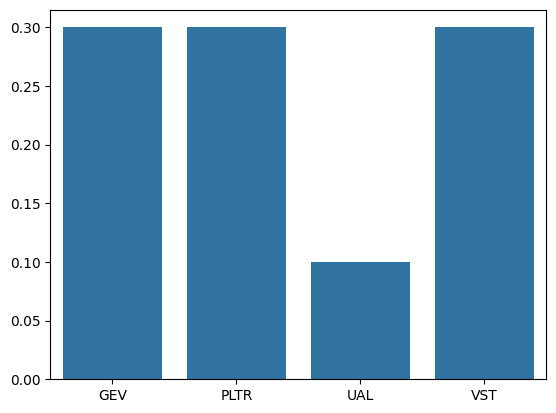

In [12]:
markowitz = -1 * result['fun']

weights =  result['x']
portfolio_return = weights @ log_returns
portfolio_std_dev = np.sqrt(weights.T @ covariance_matrix @ weights)
sharpe_ratio = portfolio_return / portfolio_std_dev

results = pd.concat([results, pd.DataFrame([[portfolio_return,  portfolio_std_dev, sharpe_ratio, 'Mean Variance optimized']], columns = results.columns)])
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Portfolio Return: {portfolio_return:.3f}")
print(f"Portfolio Standard Deviation: {portfolio_std_dev:.3f}")

# Let's plot the Weights > 0.01
sns.barplot(y=weights[weights >= 0.01], x = list(log_returns.index[weights >= 0.01]))
plt.show()

### **2. Minimize :** $ y^TQy$


TBD

###**3. Minimize : Variance**

 $\qquad$ The Minimum Variance Portfolio is designed to minimize overall risk by carefully balancing asset weights, regardless of expected return. Instead of focusing on maximizing profits, this portfolio approach seeks to create the least risky combination of assets. It does this by including assets that, when combined, offset each other's price movements—essentially reducing the portfolio’s sensitivity to market volatility. The result is a portfolio that prioritizes stability and seeks the lowest possible risk while remaining invested in a diverse set of assets.

In [13]:
result = sp.optimize.minimize(fun=calculate_portfolio_variance,
                                x0 = np.array([1/number_of_tickers for _ in range(number_of_tickers)]),
                                args=(covariance_matrix),
                                method='SLSQP',
                                bounds=tuple((0, 0.3) for _ in range(len(log_returns))),
                                constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}))

The optimization ended positively, let's print the results, and largest weights (above 0.01) :

Sharpe Ratio: 2.624
Portfolio Return: 5.6 % 
Portfolio Standard Deviation: 0.021


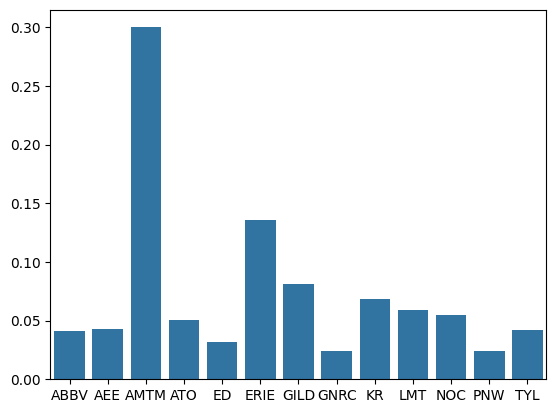

In [14]:
variance = -1 * result['fun']
weights =  result['x']
portfolio_return = weights @ log_returns
portfolio_std_dev = np.sqrt(weights.T @ covariance_matrix @ weights)
sharpe_ratio = portfolio_return / portfolio_std_dev # calculation the same sharpe ratio for all models

results = pd.concat([results, pd.DataFrame([[portfolio_return, portfolio_std_dev, sharpe_ratio, 'Variance optimized']], columns = results.columns)])
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Portfolio Return: {portfolio_return * 100:.1f} % ")
print(f"Portfolio Standard Deviation: {portfolio_std_dev:.3f}")

# Let's plot the Weights > 0.01
sns.barplot(y=weights[weights >= 0.01], x = list(log_returns.index[weights >= 0.01]))
plt.show()

***Efficiency Frontier***

 $\qquad$ The Efficient Frontier represents the set of optimal portfolios that offer the best possible return for a given level of risk. Imagine it as a curve that plots the most efficient portfolios from all possible combinations of assets—where each point on this curve reflects a unique risk-return balance. Portfolios below the frontier are suboptimal, as they either take on too much risk for their returns or achieve lower returns than possible for their risk level. By choosing a portfolio on the Efficient Frontier, investors can ensure they’re maximizing returns without taking unnecessary risks, making it a key concept in portfolio optimization.

In [ ]:
std_dev = []
returns = []
sr = []
model = []

for i, one_return in enumerate(np.linspace(portfolio_return, log_returns.max()+0.05, 20)):
    result = sp.optimize.minimize(fun=calculate_portfolio_variance,
                                x0 = np.array([1/number_of_tickers for _ in range(number_of_tickers)]),
                                args=(covariance_matrix),
                                  method='SLSQP',
                                  bounds=tuple((0, min(1, i/25 + 0.3)) for _ in range(len(log_returns))),
                                  constraints=({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                                               {'type': 'eq', 'fun': lambda weights: np.dot(weights, log_returns) - one_return}))
    portfolio_return = weights @ log_returns
    portfolio_std_dev = np.sqrt(weights.T @ covariance_matrix @ weights)
    sharpe_ratio = portfolio_return / portfolio_std_dev # calculation the same sharpe ratio for all models

    std_dev.append(portfolio_std_dev)
    returns.append(portfolio_return)
    sr.append(sharpe_ratio)
    model.append('Efficiency Frontier')

In [ ]:
efficient_frontier = pd.DataFrame({'Return':returns, 'Standard Deviation':std_dev, 'Sharpe Ratio':sr, 'Model':model})
sns.lineplot(efficient_frontier, y='Return', x='Standard Deviation')
plt.show()

### **4. Maximize : Sharpe Ratio.**



In [17]:
result = sp.optimize.minimize(fun=neg_sharpe_ratio_objective,
                            x0= np.array([1/number_of_tickers for _ in range(number_of_tickers)]),
                            args=(log_returns, covariance_matrix),
                            method='SLSQP',
                            bounds=tuple((0,0.3) for _ in range(number_of_tickers)),
                            constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}))

print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -7.11055842223685
       x: [ 0.000e+00  0.000e+00 ...  1.803e-10  0.000e+00]
     nit: 43
     jac: [ 3.775e+00  8.181e+00 ...  2.303e+01 -4.773e-01]
    nfev: 14618
    njev: 42


Sharpe Ratio: 8.039
Portfolio Return: 26.0 % 
Portfolio Standard Deviation: 0.032


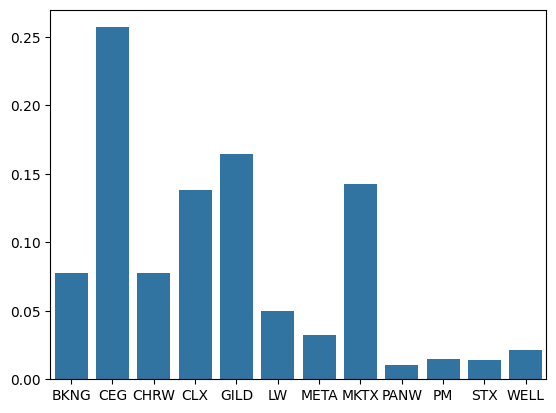

In [18]:
sharpe_ratio = -1 * result['fun']
weights =  result['x']
portfolio_return = weights @ log_returns
portfolio_std_dev = np.sqrt(weights.T @ covariance_matrix @ weights)
sharpe_ratio = portfolio_return / portfolio_std_dev # calculation the same sharpe ratio for all models

results = pd.concat([results, pd.DataFrame([[portfolio_return, portfolio_std_dev, sharpe_ratio, 'Sharpe ratio optimized']], columns = results.columns)])
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Portfolio Return: {portfolio_return * 100:.1f} % ")
print(f"Portfolio Standard Deviation: {portfolio_std_dev:.3f}")

# Let's plot the Weights > 0.01
sns.barplot(y=weights[weights >= 0.01], x = list(log_returns.index[weights >= 0.01]))
plt.show()

# Compare Results

I will first add to the result the individual asset, (similar to allocating all portfolio to 1 asset).

In [19]:
l = []
for i in range(len(std_dev_individual_stocks)) :
    l.append([log_returns.iloc[i], std_dev_individual_stocks.iloc[i], log_returns.iloc[i]/std_dev_individual_stocks.iloc[i], 'Individuals'])
results = pd.concat([results, pd.DataFrame(l, columns = results.columns)])

In [20]:
results[results['Model'] == "0.5"]

,Return,Standard Deviation,Sharpe Ratio,Model


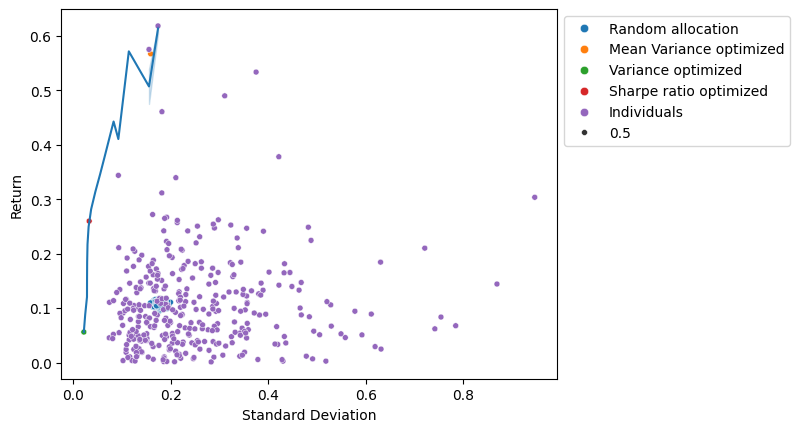

In [23]:
ax = sns.scatterplot(results, x='Standard Deviation',  y='Return', hue = 'Model', size = 0.5)
sns.lineplot(efficient_frontier, y='Return', x='Standard Deviation')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [22]:
group = results.groupby('Model')
display(group.mean())

,Return,Standard Deviation,Sharpe Ratio
Model,,,
Individuals,0.106947,0.252173,0.524666
Mean Variance optimized,0.567309,0.158502,3.579198
Random allocation,0.106946,0.177506,0.603057
Sharpe ratio optimized,0.259875,0.032329,8.038527
Variance optimized,0.055981,0.021334,2.624050


# Conclusion on Portfolio Optimization Approaches
- **Markowitz (Mean-Variance) Optimization**: Balances return and risk by selecting asset weights based on expected returns and correlations, offering a robust strategy but highly dependent on accurate inputs.
- **Random Allocation**: Simple approach with no specific optimization for risk or return; often used as a baseline, but generally less efficient in managing return-risk trade-offs.
- **Minimum Variance**: Prioritizes reducing overall portfolio risk without aiming for high returns, making it ideal for risk-averse investors; however, it may underperform in high-return environments.
- **Sharpe Ratio Optimization**: Focuses on maximizing risk-adjusted returns, providing a balanced approach between risk and return, but sensitive to the reliability of input data on returns and risk.


### Current Limitations
- **Return Estimations**: Based on the previous quarter’s data, potentially misrepresenting future returns.
- **Historical Data Constraint**: Limited to 10 years, which may not capture longer-term trends.
- **Sector Risk Ignorance**: Lacks industry or sector-specific risk assessment, which could impact portfolio resilience.
- **Absence of Sentiment Risk**: Ignores market sentiment, which can affect stock performance unpredictably.

### Next Steps
- **Enhanced Return Estimation**: Implement linear regression to estimate returns and conduct backtesting.
- **Extended Data Analysis**: Use more than 10 years of historical data for a comprehensive view.
- **Addressing Survivor Bias**: Include all stocks that were part of the S&P 500 over the last decade.
- **Additional Risk Metrics**: Incorporate new metrics to capture industry-specific and sentiment-related risks.

<br>




**Reference:**

Reha H. Tutuncu(s). (2003). Advanced Lecture on Mathematical Science and Information Science I. Retrieved from [URL](https://typeset.io/pdf/advanced-lecture-on-mathematical-science-and-information-4w2ug62u0j.pdf)